# Sentiment Analysis 

The identification of sentiment in text is an important field of study, it usually involves detecting whether a piece of text expresses a POSITIVE, a NEGATIVE, or a NEUTRAL sentiment; the sentiment can be general or about a specific topic, e.g., a person, a product, or an event.

Sentiment analysis has been part of the international workshop on Semantic Evaluation ([SemEval](https://en.wikipedia.org/wiki/SemEval)) for multiple years ([2016](http://anthology.aclweb.org/S/S16/S16-1001.pdf), [2017](http://www.aclweb.org/anthology/S17-2088)).

You task is to implement a neural network that predicts sentiment (POSITIVE, NEGATIVE, NEUTRAL) for a given text.

In the following sections, we provide the dataset preperation, a basic model, training and evaluation.


## Dataset

The dataset we are using to train and test our model is generated from German Amazon reviews.

The input is the text of the review, and the network will try to predict the star ratings.

We include only reviews with 1,3 and 5 star ratings, where: 
* 1 is considered negative
* 3 is considered neutral
* 5 is considered positive

All reviews with rating 2,4 are not included in our dataset.


### Loading the data

We already created a python script that returns amazon reviews whose star ratings are either 1,3 or 5.

In [1]:
from reviews import get_reviews
titles,bodies,ratings,labels,_ = get_reviews()

Total number of reviews: 130762
Counter({'5': 97593, '1': 17476, '3': 15693})


The number of reviews is originally not equally distributed among the ratings, so we downsampled the reviews so that there is the same number for each rating. The discarded reviews are picked at random.

In [2]:
from collections import Counter
Counter(ratings)

Counter({1: 15693, 3: 15693, 5: 15693})

#### Examples

Printing out some data examples:

In [3]:
for idx in range(40,45):
    print("body:\n %s" % bodies[idx])
    print("rating: %d" % ratings[idx])
    print("=========================================================================================")

body:
 Ich teste ja gerne mal etwas, was mit Fotografie zu tun hat- diese kleine Spielerei fürs Handy musste ich einfach ausprobieren. Und ich habe es nicht bereut!
Was ich schon mal richtig toll fand, ist die Verpackung. Kein Plastikmüll! Die Linsen waren in einem Samtsäckchen verpackt und alles in einer Papiertüte verstaut. Außerdem kamen die Linsen schon einen Tag nach meiner Bestellung an. Schon mal top!
Die kleinen Linsen lassen sich spielend leicht auswechseln. Man schraubt sie einfach auf die Klammer und setzt diese auf das Kameraauge des Handys. So lassen sich ganz schnell, ohne Bearbeitungsprogramm von einem Motiv verschiedene Optionen zaubern. Eine wirklich tolle Spielerei für den Hobbie- Fotograf. Ich habe euch ein paar Fotos geschossen, damit ihr euch ein Bild von der Wirkung der Linsen machen könnt. Von mir hat das Set die volle Kaufempfehlung. Preis- Leistung =Top!
rating: 5
body:
 Kam dreiviertelt geladen an wurde geleert und geht nach mehreren erfolglosen Ladeversuchen 

### Word Embeddings and Features

To convert text to vector space, we use [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) where words from the vocabulary are mapped to vectors of real numbers.

Multiple versions of the word embeddings have already been implemented, we use Facebook's [FastText](https://research.fb.com/fasttext/) library.

We trained our word embeddings on German wikipedia.

In [4]:
import numpy as np
import fasttext

Loading the Fasttext model (the following code might take some time to run, because the model is big)

In [5]:
fasttext_model_path = '/data/detext_tuning_0041.bin'
fasttext_model = fasttext.load_model(fasttext_model_path, encoding='utf-8')

### Question 1

What other word embedding models can we use and what are the advantages of using Fasttext?

Please write your answer in the next cell:

Next, we convert all text in the dataset into sequences of word indices. A "word index" would simply be an integer ID for the word. We will truncate the sequences to a maximum length of 200 words.
If sequences are shorter than 200, then we need to pad them with zeros

In [6]:
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = fasttext_model.dim

In [7]:
print(EMBEDDING_DIM)

100


In [8]:
from keras.preprocessing.sequence import pad_sequences 

vocabulary = dict()
inverse_vocabulary = ['PADDING']
sequences = []
for text in bodies:
    text = text.split()
    text_sequence = []
    for word in text:
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            text_sequence.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)
print("%d unique tokens in the vocabulary" %len(vocabulary))

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Using TensorFlow backend.


312421 unique tokens in the vocabulary


In [9]:
print(bodies[:2])

('Also von sich aus ist der Smartphon und die Verarbeitung sind gut,  sogar sehr gut.\nSchreiben aber  mit dem ist  absolute Horror.', 'Nach den gelesen Rezensionen, war ich doch nach sehen des Films etwas enttäuscht. Ich kenne das Original nicht, aber mir kommt diese Verfilmung doch sehr oberflächlich daher. Man hätte aus diesem Stoff doch mehr herausholen können. Die verschiedenen Charakter der Brüder und auch was der Krieg aus einem Menschen machen kann, hätte man noch intensiver darstellen können. Die Schauspieler fand ich alle sehr gut. Kann ihn zwar empfehlen, aber finde ihn in den Rezensionen überbewertet.')


In [10]:
import re
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"\n", "",  text)
    text = re.sub(r"[-()]", "", text)
    text = re.sub(r"\.", " .", text)
    text = re.sub(r"\!", " !", text)
    text = re.sub(r"\?", " ?", text)
    text = re.sub(r"\,", " ,", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"ohh", "oh", text)
    text = re.sub(r"ohhh", "oh", text)
    text = re.sub(r"ohhhh", "oh", text)
    text = re.sub(r"ohhhhh", "oh", text)
    text = re.sub(r"ohhhhhh", "oh", text)
    text = re.sub(r"ahh", "ah", text)
    
    return text

In [11]:
bodies2 = []
for line in bodies:
    bodies2.append(clean_text(line))

In [12]:
bodies=bodies2

In [13]:
from keras.preprocessing.sequence import pad_sequences 

vocabulary = dict()
inverse_vocabulary = ['PADDING']
sequences = []
for text in bodies:
    text = text.split()
    text_sequence = []
    for word in text:
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            text_sequence.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            text_sequence.append(vocabulary[word])
    sequences.append(text_sequence)
print("%d unique tokens in the vocabulary" %len(vocabulary))

bodies_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

210605 unique tokens in the vocabulary


In [14]:
print(bodies[:2])

['also von sich aus ist der smartphon und die verarbeitung sind gut ,  sogar sehr gut .schreiben aber  mit dem ist  absolute horror .', 'nach den gelesen rezensionen , war ich doch nach sehen des films etwas enttäuscht . ich kenne das original nicht , aber mir kommt diese verfilmung doch sehr oberflächlich daher . man hätte aus diesem stoff doch mehr herausholen können . die verschiedenen charakter der brüder und auch was der krieg aus einem menschen machen kann , hätte man noch intensiver darstellen können . die schauspieler fand ich alle sehr gut . kann ihn zwar empfehlen , aber finde ihn in den rezensionen überbewertet .']


### Question 2

As you can see, there is a huge number of unique tokens extracted from the reviews. Can you think of any preprocessing steps to make the vocabulary smaller?

Edit the code block above to add more preprocessing steps.


### Splitting into Train/Val/Test Sets

Split the dataset into 3 sets: train, validation and test.

We use ```sklearn.model_selection.train_test_split``` twice. First to split to train, val and then split val again into val and test. 

In [15]:
from sklearn.model_selection import train_test_split

data = {
    'train': {},
    'val': {},
    'test': {},
}

(data['train']['text'],
 data['val']['text'],
 data['train']['y'],
 data['val']['y']
) = train_test_split(bodies_seq, labels, test_size=0.1)

(data['val']['text'],
 data['test']['text'],
 data['val']['y'],
 data['test']['y']
) = train_test_split(data['val']['text'], data['val']['y'], test_size=0.1)

print('Train: {} examples'.format(len(data['train']['y'])))
print('Val: {} examples'.format(len(data['val']['y'])))
print('Test: {} examples'.format(len(data['test']['y'])))

Train: 42371 examples
Val: 4237 examples
Test: 471 examples


## Neural Network

In [16]:
import keras
from keras import layers
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from IPython import display

### The Embedding layer

Prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

In [17]:
embedding_matrix = np.zeros((len(vocabulary) + 1, EMBEDDING_DIM)) 
for word, i in vocabulary.items():
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

### Question 3

How should we handle a word that is not found in the embeddings model (out of vocabulary words)?

Please write your answer in the next cell:

In [18]:
print(MAX_SEQUENCE_LENGTH)
print(EMBEDDING_DIM)

200
100


### Model Definition

In [19]:
class BaselineModel(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding',
                            trainable=False)(input_layer)
            
        fc_layer = layers.Dense(
            units=100,
            name='FullyConnected'
        )(embedding_layer)
        
        fc_layer  = layers.Flatten(name="Flatten")(fc_layer)
        
        predictions = layers.Dense(
            3,
            name='Output'
        )(fc_layer)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [20]:
model = BaselineModel()
model.compile()

In [21]:
display.display(display.Image(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create_png()))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

### Model Training

In [24]:
history = model.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=128
)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=42371), HTML(value='')))

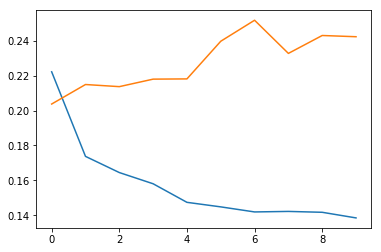

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

### Question 4

This model is very simple, it consists of only the embedding layer and one dense layer. By looking at the graph above, you can see that the model is not generelizing well on the validation set, when does that usually happen and what can we do to improve it? 

Please write your answer in the next cell:

In [102]:
''' Generalization normally fails in Validation when model get overfit to Training data. To prevent overfitting, we can -
1. Add more Data
2. Use models with variations and average out their output. i.e. -
    a. Either using models of different forms
    b. Or through Bagging approach i.e. training it on different subsets of Training data.
3. Control the capacity/flexibility of model. It can be done by - 
    a. Early stopping before it overfits
    b. Controlling architecture -- limiting no. of hidden layers
    c. Adding Noise
    d. Penalizing large weights
4. Taking average of predictions generated by varying Weight vectors.
5. Use dropout layers
'''

' Generalization normally fails in Validation when model get overfit to Training data. To prevent overfitting, we can -\n1. Add more Data\n2. Use models with variations and average out their output. i.e. -\n    a. Either using models of different forms\n    b. Or through Bagging approach i.e. training it on different subsets of Training data.\n3. Control the capacity/flexibility of model. It can be done by - \n    a. Early stopping before it overfits\n    b. Controlling architecture -- limiting no. of hidden layers\n    c. Adding Noise\n    d. Penalizing large weights\n4. Taking average of predictions generated by varying Weight vectors.\n'

### Model Evaluation

Let's use accuracy to evaluate our model:

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
h = model.predict([data['test']['text']])

In [29]:
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 471 test samples: 0.545648


### Question 5

As you can see, this model is not performing well. What would you change in this model to increase its accuracy?

Please write your answer in the next cell:

In [103]:
'''
There can be several ways to improve the model -
1. We can intoduce more layers like convolution along with pooling etc. And test with different architectures of CNN
2. We can use RNN network like LSTM, which stores previous state in memory.
'''

'\nThere can be several ways to improve the model -\n1. We can intoduce more layers like convolution along with pooling etc. And test with different architectures of CNN\n2. We can use RNN network like LSTM, which stores previous state in memory.\n'

### Inference

In [30]:
def infer(texts):
    sequences = []
    for text in texts:
        text = text.split()
        text_sequence = []
        for word in text:
            if word in vocabulary:
                text_sequence.append(vocabulary[word])
        sequences.append(text_sequence)

    padded_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict([padded_seq])
    

In [31]:
text = ['das ist schlecht',
       'ich finde das echt toll',
       'das ist gut',
       'das ist nicht schlecht',
       'das ist nicht gut',
       'okay vielen dank',]

In [32]:
h_ = infer(text)
for i,t in enumerate(text):
    print('{} {} {}'.format(
            np.argmax(h_[i]),
            h_[i],
            t[:MAX_SEQUENCE_LENGTH],
        ))

0 [ 0.40850994  0.21610351  0.28963226] das ist schlecht
0 [ 0.4200699   0.13947555  0.36822423] ich finde das echt toll
2 [ 0.29508847  0.22653696  0.39167821] das ist gut
0 [ 0.45426169  0.22597839  0.2401565 ] das ist nicht schlecht
2 [ 0.34084019  0.23641184  0.34220243] das ist nicht gut
2 [ 0.15376954  0.19991808  0.56166852] okay vielen dank


### Question 6

Implement a model similar to the one described in [this paper](https://arxiv.org/pdf/1704.06125.pdf), in order to get a much higher accuracy.

In [96]:
from keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Reshape, Dropout
from keras.models import Model


class BaselineModel2(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            name='Embedding',
                            trainable=False)(input_layer)

        conv1 = Conv1D(200, 2, activation='relu')(embedding_layer)
        conv2 = Conv1D(200, 3, activation='relu')(embedding_layer)
        conv3 = Conv1D(200, 4, activation='relu')(embedding_layer)
        
        pool1 = GlobalMaxPooling1D()(conv1)
        pool2 = GlobalMaxPooling1D()(conv2)
        pool3 = GlobalMaxPooling1D()(conv3)
        
        conc_layer = keras.layers.concatenate([pool3, pool2, pool1])
        drop1 = Dropout(0.5)(conc_layer)
        fc_layer1 = layers.Dense(units=30,name='FullyConnected')(drop1)
        drop2 = Dropout(0.5)(fc_layer1)
        #fc_layer2 = layers.Flatten(name="Flatten")(drop2)
        predictions = Dense(3, activation='softmax')(drop2)
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [97]:
model2 = BaselineModel2()
model2.compile()

In [98]:
#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model2, show_shapes=True).create_png()))

In [99]:
history = model2.fit(
    [data['train']['text']],
    keras.utils.to_categorical(data['train']['y'],3),
    epochs=10,
    verbose=0,
    callbacks=[
        TQDMNotebookCallback(
            leave_inner=True,
        )
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=128
)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=42371), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=42371), HTML(value='')))

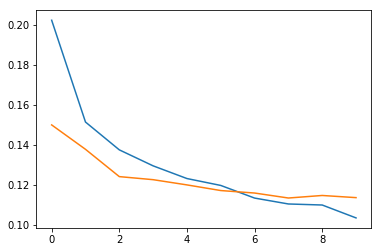

In [100]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

In [101]:
from sklearn.metrics import accuracy_score
h = model2.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

Accuracy score on 471 test samples: 0.728238


In [59]:
from keras.layers import Input, Dense, GlobalMaxPooling1D, Bidirectional, LSTM
from keras.models import Model


class BaselineModel3(keras.models.Model):
    
    def __init__(self):
        input_layer = layers.Input(
            shape=(MAX_SEQUENCE_LENGTH,),
            name='Input'
        )
        print(input_layer.shape)
        embedding_layer = layers.Embedding(len(vocabulary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            name='Embedding',
                            trainable=False)(input_layer)
        print(embedding_layer.shape)
        drop1 = Dropout(0.5)(embedding_layer)
        bi_lay = Bidirectional(LSTM(200, return_sequences=False))(drop1)
        drop2 = Dropout(0.5)(bi_lay)
        print(drop2.shape)
        f_con = Dense(30, activation="sigmoid")(drop2)
        drop3 = Dropout(0.5)(f_con)
        print(drop3.shape)
        predictions = Dense(3, activation='softmax')(drop3)
        
        super().__init__(inputs=[input_layer], outputs=predictions)
        
    def compile(self):
        return super().compile(
            optimizer=keras.optimizers.Adam(lr=0.001),
            loss='mse'
        )

In [60]:
model3 = BaselineModel3()
model3.compile()

(?, 200)
(?, 200, 100)
(?, ?, 400)
(?, 200, 30)


In [63]:
print(data['train']['text'].shape)

(42371, 200)


In [61]:
#display.display(display.Image(keras.utils.vis_utils.model_to_dot(model3, show_shapes=True).create_png()))

In [62]:
history = model3.fit([data['train']['text'].reshape()],keras.utils.to_categorical(data['train']['y'],3),
                     epochs=10,verbose=0,callbacks=[TQDMNotebookCallback(leave_inner=True,)
    ],
    validation_data=(
        [data['val']['text']],
        keras.utils.to_categorical(data['val']['y'],3)
    ),
    batch_size=32
)

ValueError: Error when checking target: expected dense_11 to have 3 dimensions, but got array with shape (42371, 3)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['loss'],history.epoch,history.history['val_loss'])
plt.show()
_=_

In [ ]:
from sklearn.metrics import accuracy_score
h = model2.predict([data['test']['text']])
predict = np.asarray([np.argmax(i) for i in h])
gold = np.asarray(data['test']['y'])
resultf1 = accuracy_score(gold, predict)
print('Accuracy score on {} test samples: {:.6}'.format(
    len(predict), resultf1
))

In [26]:

import numpy as np
a= np.random.rand(8,6)
b=np.random.rand(3,)
c=np.random.rand(4,1)
#print((a+b).shape) 
print(b)
print(c)
print(a[:2,1:4])

[0.9595083  0.26233734 0.30014796]
[[0.95685904]
 [0.90399242]
 [0.78772734]
 [0.52574663]]
[[0.5834513  0.14647375 0.14317278]
 [0.05805849 0.22996969 0.32466572]]
